In [1]:
#Import required libraries

In [2]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [3]:
#Loading data
ratings = pd.read_csv("ratings_Electronics.csv", sep=",", error_bad_lines=False)
ratings.columns = ['userId', 'productId', 'rating', 'timestamp']

# Checking the shape of data

In [4]:
ratings.shape

(7824481, 4)

In [5]:
# About 7.8 million records

# Exploring dataset

In [6]:
ratings.head()

userId   productId  rating   timestamp
0  A2CX7LUOHB2NDG  0321732944     5.0  1341100800
1  A2NWSAGRHCP8N5  0439886341     1.0  1367193600
2  A2WNBOD3WNDNKT  0439886341     3.0  1374451200
3  A1GI0U4ZRJA8WN  0439886341     1.0  1334707200
4  A1QGNMC6O1VW39  0511189877     5.0  1397433600

# Drop timestamp column as it is not required for analysis

In [7]:
ratings = ratings.iloc[:,:3]

In [8]:
ratings.head()

userId   productId  rating
0  A2CX7LUOHB2NDG  0321732944     5.0
1  A2NWSAGRHCP8N5  0439886341     1.0
2  A2WNBOD3WNDNKT  0439886341     3.0
3  A1GI0U4ZRJA8WN  0439886341     1.0
4  A1QGNMC6O1VW39  0511189877     5.0

In [9]:
ratings.dtypes

userId        object
productId     object
rating       float64
dtype: object

In [10]:
#check the unique ratings

In [11]:
ratings['rating'].unique()

array([5., 1., 3., 2., 4.])

In [12]:
#Ratings are in the range of 1-5

In [13]:
#Get the count of ratings

In [14]:
ratings.rating.value_counts()

5.0    4347540
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: rating, dtype: int64

In [15]:
# 5.0 is the highest rated 

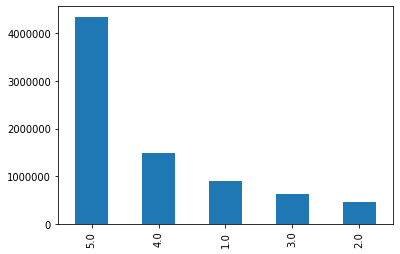

In [16]:
ratings.rating.value_counts().plot(kind='bar')
plt.show()

In [17]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   rating     float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [18]:
ratings.isnull().sum()

userId       0
productId    0
rating       0
dtype: int64

In [19]:
# None of the values are missing

In [20]:
ratings.describe().T

count      mean      std  min  25%  50%  75%  max
rating  7824481.0  4.012337  1.38091  1.0  3.0  5.0  5.0  5.0

In [21]:
ratings.groupby('productId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

productId  rating
308397  B0074BW614   18244
429571  B00DR0PDNE   16454
327307  B007WTAJTO   14172
102803  B0019EHU8G   12285
296624  B006GWO5WK   12226
178600  B003ELYQGG   11617
178812  B003ES5ZUU   10276
323012  B007R5YDYA    9907
289774  B00622AG6S    9823
30275   B0002L5R78    9487

In [22]:
# Most rated product has received 18244 ratings

In [23]:
# Plotting the top 30 products

In [24]:
most_popular = ratings.groupby('productId')['rating'].count().reset_index().sort_values('rating', ascending=False)

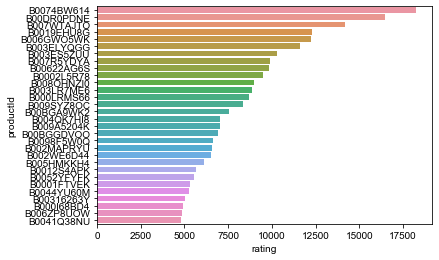

In [25]:
sns.barplot(x="rating", y="productId", data=most_popular.head(30))
sns.set(rc={'figure.figsize':(10,10)})

In [26]:
ratings.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

userId  rating
3263531   A5JLAU2ARJ0BO     520
3512451    ADLVFFE4VBT8     501
2989526  A3OXHLG6DIBRW8     498
3291008    A6FIAB28IS79     431
3284634   A680RUE1FDO8B     406
755206   A1ODOGXEYECQQ8     380
2424036  A36K2N527TXXJN     314
1451394  A2AY4YUOX2N1BQ     311
4100926   AWPODHOB4GFWL     308
3935038   ARBKYIVNYWK3C     296

In [27]:
#User A5JLAU2ARJ0BO has rated 520 products

In [28]:
# Let's analyse the product ratings distributions

In [29]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = ratings['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / ratings.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} product-ratings'.format(ratings.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [30]:
# We can see that most of the products are having 5 rating, i.e. more than 50% ratings are rated good

In [31]:
# Rating distribution by Product

In [32]:
# Number of ratings per product
data = ratings.groupby('productId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Product (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Product'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [33]:
# We can see that most of the products users have not rated, lot of products are have approximately 10 ratings

In [34]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', ratings['userId'].nunique())
print('Number of unique PRODUCTS in Raw data = ', ratings['productId'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique PRODUCTS in Raw data =  476001


# Converting the dataset to dense by keeping users who has given 50 or more ratings and Products which has 50 or more ratings 

In [35]:
min_product_ratings = 50
filter_products = ratings['productId'].value_counts() > min_product_ratings
filter_products = filter_products[filter_products].index.tolist()

In [36]:
min_user_ratings = 50
filter_users = ratings['userId'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

In [37]:
ratings_new = ratings[(ratings['productId'].isin(filter_products)) & (ratings['userId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(ratings.shape))
print('The new data frame shape:\t{}'.format(ratings_new.shape))

The original data frame shape:	(7824481, 3)
The new data frame shape:	(76359, 3)


In [38]:
final_ratings_matrix = ratings_new.pivot(index = 'userId', columns ='productId', values = 'rating')

final_ratings_matrix = final_ratings_matrix.fillna(final_ratings_matrix.mean(axis=0))
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (1466, 16555)
given_num_of_ratings =  24269630
possible_num_of_ratings =  24269630
density: 100.00%


In [39]:
final_ratings_matrix.head()

productId       0972683275  1400501466  1400501520  1400501776  1400532620  \
userId                                                                       
A100UD67AHFODS         5.0         3.0         5.0         4.5         3.0   
A100WO06OQR8BQ         5.0         3.0         5.0         4.5         3.0   
A105S56ODHGJEK         5.0         3.0         5.0         4.5         3.0   
A105TOJ6LTVMBG         5.0         3.0         5.0         4.5         3.0   
A10AFVU66A79Y1         5.0         3.0         5.0         4.5         3.0   

productId       1400532655  140053271X  1400599997  1400698987  3744295508  \
userId                                                                       
A100UD67AHFODS         3.6         2.5        3.75         4.5         5.0   
A100WO06OQR8BQ         3.6         2.5        3.75         4.5         5.0   
A105S56ODHGJEK         3.6         2.5        3.75         4.5         5.0   
A105TOJ6LTVMBG         3.6         2.5        3.75         4.5         5.0   
A10AFVU66A79Y1         3.6         2.5        3.75         4.5         5.0   

productId       ...  B00JTI4X3E  B00JX1ZS5O  B00K0OBEE2  B00K4VQZCM  \
userId          ...                                                   
A100UD67AHFODS  ...         3.0    4.833333         5.0         5.0   
A100WO06OQR8BQ  ...         3.0    4.833333         5.0         5.0   
A105S56ODHGJEK  ...         3.0    4.833333         5.0         5.0   
A105TOJ6LTVMBG  ...         3.0    4.833333         5.0         5.0   
A10AFVU66A79Y1  ...         3.0    4.833333         5.0         5.0   

productId       B00K7O2DJU  B00K91DB7Y  B00KFAGCUM  B00KINSDK8  B00KWHMR6G  \
userId                                                                       
A100UD67AHFODS         4.0    4.153846    4.857143         5.0         1.5   
A100WO06OQR8BQ         4.0    1.000000    4.857143         5.0         1.5   
A105S56ODHGJEK         4.0    4.153846    4.857143         5.0         1.5   
A105TOJ6LTVMBG         4.0    4.153846    4.857143         5.0         1.5   
A10AFVU66A79Y1         4.0    4.153846    4.857143         5.0         1.5   

productId       B00L3YHF6O  
userId                      
A100UD67AHFODS         5.0  
A100WO06OQR8BQ         5.0  
A105S56ODHGJEK         5.0  
A105TOJ6LTVMBG         5.0  
A10AFVU66A79Y1         5.0  

[5 rows x 16555 columns]

In [40]:
from surprise import Reader, Dataset

In [41]:
reader = Reader(rating_scale=(1, 5))

In [42]:
data = Dataset.load_from_df(ratings_new[['userId', 'productId', 'rating']], reader)

# Split the data into train and test set

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
train_data, test_data = train_test_split(ratings_new, test_size=0.3,random_state=123)

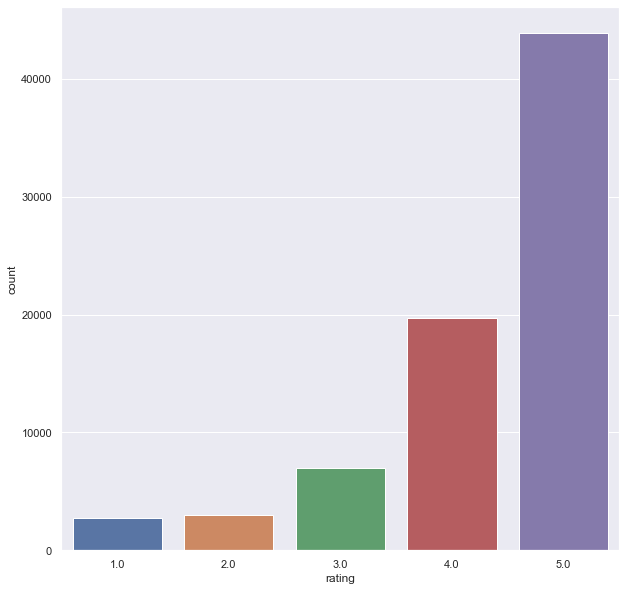

In [45]:
#plotting count of bookRating
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data=ratings_new , x='rating')
plt.show()

# Build Popularity Based Model

In [46]:
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head()

productId  score
0  0972683275      2
1  1400501466      5
2  1400501520      1
3  1400501776      1
4  1400532620      1

In [47]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

productId  score  Rank
11912  B0088CJT4U    148   1.0
7285   B003ES5ZUU    126   2.0
2826   B000N99BBC    111   3.0
11706  B007WTAJTO    110   4.0
12020  B008DWCRQW    103   5.0

In [48]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [49]:
find_recom = ['A36K2N527TXXJN','A3OXHLG6DIBRW8','AWPODHOB4GFWL']   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %s\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: A36K2N527TXXJN

               userId   productId  score  Rank
11912  A36K2N527TXXJN  B0088CJT4U    148   1.0
7285   A36K2N527TXXJN  B003ES5ZUU    126   2.0
2826   A36K2N527TXXJN  B000N99BBC    111   3.0
11706  A36K2N527TXXJN  B007WTAJTO    110   4.0
12020  A36K2N527TXXJN  B008DWCRQW    103   5.0


Here is the recommendation for the userId: A3OXHLG6DIBRW8

               userId   productId  score  Rank
11912  A3OXHLG6DIBRW8  B0088CJT4U    148   1.0
7285   A3OXHLG6DIBRW8  B003ES5ZUU    126   2.0
2826   A3OXHLG6DIBRW8  B000N99BBC    111   3.0
11706  A3OXHLG6DIBRW8  B007WTAJTO    110   4.0
12020  A3OXHLG6DIBRW8  B008DWCRQW    103   5.0


Here is the recommendation for the userId: AWPODHOB4GFWL

              userId   productId  score  Rank
11912  AWPODHOB4GFWL  B0088CJT4U    148   1.0
7285   AWPODHOB4GFWL  B003ES5ZUU    126   2.0
2826   AWPODHOB4GFWL  B000N99BBC    111   3.0
11706  AWPODHOB4GFWL  B007WTAJTO    110   4.0
12020  AWPODHOB4GFWL  B008

In [50]:
# Polpularity based model recommends same set of products to each user

# Model - based Collaborative Filtering System

In [51]:
# train and test data from Surprise Library

In [52]:
from surprise.model_selection import train_test_split

In [53]:
train_data, test_data = train_test_split(data, test_size=0.3,random_state=123)

# Let's apply KNNWithMeans
# KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

In [54]:
from surprise import KNNWithMeans
from surprise import accuracy

algoKNNMeans = KNNWithMeans(k=10, sim_options={ 'user_based': False})

algoKNNMeans.fit(train_data)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [55]:
knn_test_pred=algoKNNMeans.test(test_data)
print(accuracy.rmse(knn_test_pred))

RMSE: 1.1231
1.12311278854733


In [56]:
#Let's perform cross validation with KNNWithMeans

In [57]:
from surprise.model_selection import cross_validate

In [58]:
results = cross_validate(algoKNNMeans, data, measures=['RMSE'], cv=3, verbose=False)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [59]:
knnWithMeansCrossValidationResult = pd.DataFrame.from_dict(results).mean(axis=0)

In [60]:
print('Cross Validation score is {r}'.format(r=knnWithMeansCrossValidationResult['test_rmse']))

Cross Validation score is 1.1223213206820286


# Try SVD Based Recommendation System

In [61]:
from surprise import SVD

In [62]:
svd_model = SVD(n_factors=10,biased=False)
svd_model.fit(train_data)

In [63]:
test_pred = svd_model.test(test_data)

In [64]:
# compute RMSE on test data
accuracy.rmse(test_pred)

RMSE: 1.7969


1.7968983732809922

In [65]:
# Cross validation with SVD

In [66]:
results = cross_validate(svd_model, data, measures=['RMSE'], cv=3, verbose=False)

In [67]:
SVDCrossValidationResult = pd.DataFrame.from_dict(results).mean(axis=0)

In [68]:
print('Cross Validation score is {r}'.format(r=SVDCrossValidationResult['test_rmse']))

Cross Validation score is 1.9400593213784303


# KNNWithMeans is giving better results

In [69]:
knn_test_pred

[Prediction(uid='A1URXSRV6WDHVY', iid='B0001XGQTA', r_ui=5.0, est=5, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='A2ALRZ0ENQLYY5', iid='B00004ZCJE', r_ui=3.0, est=4.004405225009958, details={'actual_k': 6, 'was_impossible': False}),
 Prediction(uid='AC6Z7DP1Z5GHD', iid='B0009H5VVM', r_ui=5.0, est=4.25, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='ALUNVOQRXOZIA', iid='B000MP831G', r_ui=5.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A1BT6TL7UCIC5Y', iid='B00176TEGM', r_ui=5.0, est=4.27130381273334, details={'actual_k': 10, 'was_impossible': False}),
 Prediction(uid='A2B7BUH8834Y6M', iid='B000NP46K2', r_ui=5.0, est=4.805299539170507, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A1Y051MQ2SVPFI', iid='B005IHAIC0', r_ui=5.0, est=4.707142857142856, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A19X4BF861LQST', iid='B0014LA4NM', r_ui=3.0, est=4.0, details={'actual_k': 0, 

# Get Top 5 recommendations 

In [70]:
pred = pd.DataFrame(knn_test_pred)

In [71]:
pred.head()

uid         iid  r_ui       est  \
0  A1URXSRV6WDHVY  B0001XGQTA   5.0  5.000000   
1  A2ALRZ0ENQLYY5  B00004ZCJE   3.0  4.004405   
2   AC6Z7DP1Z5GHD  B0009H5VVM   5.0  4.250000   
3   ALUNVOQRXOZIA  B000MP831G   5.0  5.000000   
4  A1BT6TL7UCIC5Y  B00176TEGM   5.0  4.271304   

                                     details  
0   {'actual_k': 3, 'was_impossible': False}  
1   {'actual_k': 6, 'was_impossible': False}  
2   {'actual_k': 0, 'was_impossible': False}  
3   {'actual_k': 1, 'was_impossible': False}  
4  {'actual_k': 10, 'was_impossible': False}

In [72]:
pred[pred['uid'] == 'A36K2N527TXXJN'][['iid', 'r_ui','est']].sort_values(by = 'r_ui',ascending = False).head(5)

iid  r_ui       est
12447  B003BERYLA   5.0  4.297712
17350  B00DK2JQOQ   5.0  4.725644
15899  B004GW25WY   5.0  4.858137
14999  B001TH7GVE   5.0  4.727138
17675  B003FMUP3W   5.0  4.297712

In [73]:
pred[pred['uid'] == 'A3OXHLG6DIBRW8'][['iid', 'r_ui','est']].sort_values(by = 'r_ui',ascending = False).head(5)

iid  r_ui       est
52     B0000510T7   5.0  5.000000
10534  B0093AN1OA   5.0  5.000000
11832  B007KEZMX4   5.0  4.865465
11895  B000X5ZVS8   5.0  3.569114
12615  B000WKW69Q   5.0  4.650367

In [74]:
pred[pred['uid'] == 'AWPODHOB4GFWL'][['iid', 'r_ui','est']].sort_values(by = 'r_ui',ascending = False).head(5)

iid  r_ui       est
19134  B00005T3ND   5.0  2.949512
8820   B001FA1NK0   5.0  4.518815
17804  B0079TOEQQ   5.0  3.949550
12516  B0052OZZYK   5.0  5.000000
17828  B00KINSDK8   5.0  4.297712

In [75]:
# For user A100UD67AHFODS

In [76]:
pred[pred['uid'] == 'A100UD67AHFODS'][['iid', 'r_ui','est']].sort_values(by = 'r_ui',ascending = False).head(5)

iid  r_ui       est
10357  B00ALNPM2C   5.0  4.297712
9782   B005PQTYHE   5.0  5.000000
22046  B0082E9K7U   5.0  4.293815
20068  B004LU1U2M   5.0  4.520000
16545  B001A5FH9S   5.0  5.000000

# User Based Collaborative Filtering 

In [77]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
org_pivot_df = ratings_new.pivot(index = 'userId', columns ='productId', values = 'rating').fillna(final_ratings_matrix.mean(axis=0))
pivot_df = org_pivot_df.copy(deep=True)
pivot_df.head()

productId       0972683275  1400501466  1400501520  1400501776  1400532620  \
userId                                                                       
A100UD67AHFODS         5.0         3.0         5.0         4.5         3.0   
A100WO06OQR8BQ         5.0         3.0         5.0         4.5         3.0   
A105S56ODHGJEK         5.0         3.0         5.0         4.5         3.0   
A105TOJ6LTVMBG         5.0         3.0         5.0         4.5         3.0   
A10AFVU66A79Y1         5.0         3.0         5.0         4.5         3.0   

productId       1400532655  140053271X  1400599997  1400698987  3744295508  \
userId                                                                       
A100UD67AHFODS         3.6         2.5        3.75         4.5         5.0   
A100WO06OQR8BQ         3.6         2.5        3.75         4.5         5.0   
A105S56ODHGJEK         3.6         2.5        3.75         4.5         5.0   
A105TOJ6LTVMBG         3.6         2.5        3.75         4.5         5.0   
A10AFVU66A79Y1         3.6         2.5        3.75         4.5         5.0   

productId       ...  B00JTI4X3E  B00JX1ZS5O  B00K0OBEE2  B00K4VQZCM  \
userId          ...                                                   
A100UD67AHFODS  ...         3.0    4.833333         5.0         5.0   
A100WO06OQR8BQ  ...         3.0    4.833333         5.0         5.0   
A105S56ODHGJEK  ...         3.0    4.833333         5.0         5.0   
A105TOJ6LTVMBG  ...         3.0    4.833333         5.0         5.0   
A10AFVU66A79Y1  ...         3.0    4.833333         5.0         5.0   

productId       B00K7O2DJU  B00K91DB7Y  B00KFAGCUM  B00KINSDK8  B00KWHMR6G  \
userId                                                                       
A100UD67AHFODS         4.0    4.153846    4.857143         5.0         1.5   
A100WO06OQR8BQ         4.0    1.000000    4.857143         5.0         1.5   
A105S56ODHGJEK         4.0    4.153846    4.857143         5.0         1.5   
A105TOJ6LTVMBG         4.0    4.153846    4.857143         5.0         1.5   
A10AFVU66A79Y1         4.0    4.153846    4.857143         5.0         1.5   

productId       B00L3YHF6O  
userId                      
A100UD67AHFODS         5.0  
A100WO06OQR8BQ         5.0  
A105S56ODHGJEK         5.0  
A105TOJ6LTVMBG         5.0  
A10AFVU66A79Y1         5.0  

[5 rows x 16555 columns]

In [78]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

productId   0972683275  1400501466  1400501520  1400501776  1400532620  \
user_index                                                               
0                  5.0         3.0         5.0         4.5         3.0   
1                  5.0         3.0         5.0         4.5         3.0   
2                  5.0         3.0         5.0         4.5         3.0   
3                  5.0         3.0         5.0         4.5         3.0   
4                  5.0         3.0         5.0         4.5         3.0   

productId   1400532655  140053271X  1400599997  1400698987  3744295508  ...  \
user_index                                                              ...   
0                  3.6         2.5        3.75         4.5         5.0  ...   
1                  3.6         2.5        3.75         4.5         5.0  ...   
2                  3.6         2.5        3.75         4.5         5.0  ...   
3                  3.6         2.5        3.75         4.5         5.0  ...   
4                  3.6         2.5        3.75         4.5         5.0  ...   

productId   B00JTI4X3E  B00JX1ZS5O  B00K0OBEE2  B00K4VQZCM  B00K7O2DJU  \
user_index                                                               
0                  3.0    4.833333         5.0         5.0         4.0   
1                  3.0    4.833333         5.0         5.0         4.0   
2                  3.0    4.833333         5.0         5.0         4.0   
3                  3.0    4.833333         5.0         5.0         4.0   
4                  3.0    4.833333         5.0         5.0         4.0   

productId   B00K91DB7Y  B00KFAGCUM  B00KINSDK8  B00KWHMR6G  B00L3YHF6O  
user_index                                                              
0             4.153846    4.857143         5.0         1.5         5.0  
1             1.000000    4.857143         5.0         1.5         5.0  
2             4.153846    4.857143         5.0         1.5         5.0  
3             4.153846    4.857143         5.0         1.5         5.0  
4             4.153846    4.857143         5.0         1.5         5.0  

[5 rows x 16555 columns]

In [79]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [80]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId  0972683275  1400501466  1400501520  1400501776  1400532620  \
0            5.000763    3.000019    5.000763    4.500806    3.000816   
1            5.000097    3.014291    5.000097    4.521660    3.002838   
2            5.000131    2.999981    5.000131    4.500161    3.000011   
3            4.998613    2.998736    4.998613    4.499031    2.998691   
4            5.000100    2.999160    5.000100    4.500072    2.999493   

productId  1400532655  140053271X  1400599997  1400698987  3744295508  ...  \
0            3.601833    2.500368    3.752415    4.500690    5.000763  ...   
1            3.643964    2.504691    3.772010    4.495106    5.000097  ...   
2            3.602150    2.500040    3.750124    4.500099    5.000131  ...   
3            3.597539    2.499160    3.748453    4.498907    4.998613  ...   
4            3.604512    2.500341    3.748587    4.500045    5.000100  ...   

productId  B00JTI4X3E  B00JX1ZS5O  B00K0OBEE2  B00K4VQZCM  B00K7O2DJU  \
0            3.000458    4.833598    5.000763    5.000763    4.000717   
1            3.000058    4.827907    5.000097    5.000097    3.987228   
2            3.000078    4.833942    5.000131    5.000131    4.000019   
3            2.999168    4.830356    4.998613    4.998613    3.998602   
4            3.000060    4.836443    5.000100    5.000100    3.999568   

productId  B00K91DB7Y  B00KFAGCUM  B00KINSDK8  B00KWHMR6G  B00L3YHF6O  
0            4.159249    4.858289    5.000763    1.500556    5.000763  
1            1.577557    4.847474    5.000097    1.494632    5.000097  
2            4.161043    4.857341    5.000131    1.498746    5.000131  
3            4.144499    4.856352    4.998613    1.501390    4.998613  
4            4.170771    4.857567    5.000100    1.497098    5.000100  

[5 rows x 16555 columns]

In [81]:
# Recommend the items with the highest predicted ratings

def recommend_items(user, pivot_df, preds_df, num_recommendations, userIndexList):
      
    user_idx = userIndexList.index(user)
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.sort_values('user_predictions', ascending=False)
    
    print('\nBelow are the recommended items for user {}:\n'.format(user))
    print(temp.head(num_recommendations))

In [82]:
#Enter 'userID' and 'num_recommendations' for the user #
user = 'A100UD67AHFODS'
num_recommendations = 5
recommend_items(user, pivot_df, preds_df, num_recommendations,list(org_pivot_df.index))


Below are the recommended items for user A100UD67AHFODS:

                   user_ratings  user_predictions
Recommended Items                                
B00L3YHF6O                  5.0          5.000763
B000U0S304                  5.0          5.000763
B000TXNS6G                  5.0          5.000763
B000TLVMIO                  5.0          5.000763
B000TFNLAW                  5.0          5.000763


In [83]:
# Average ACTUAL rating for each product
final_ratings_matrix.mean().head()

productId
0972683275    5.0
1400501466    3.0
1400501520    5.0
1400501776    4.5
1400532620    3.0
dtype: float64

In [84]:
# Predicted ratings 
preds_df.head()

productId  0972683275  1400501466  1400501520  1400501776  1400532620  \
0            5.000763    3.000019    5.000763    4.500806    3.000816   
1            5.000097    3.014291    5.000097    4.521660    3.002838   
2            5.000131    2.999981    5.000131    4.500161    3.000011   
3            4.998613    2.998736    4.998613    4.499031    2.998691   
4            5.000100    2.999160    5.000100    4.500072    2.999493   

productId  1400532655  140053271X  1400599997  1400698987  3744295508  ...  \
0            3.601833    2.500368    3.752415    4.500690    5.000763  ...   
1            3.643964    2.504691    3.772010    4.495106    5.000097  ...   
2            3.602150    2.500040    3.750124    4.500099    5.000131  ...   
3            3.597539    2.499160    3.748453    4.498907    4.998613  ...   
4            3.604512    2.500341    3.748587    4.500045    5.000100  ...   

productId  B00JTI4X3E  B00JX1ZS5O  B00K0OBEE2  B00K4VQZCM  B00K7O2DJU  \
0            3.000458    4.833598    5.000763    5.000763    4.000717   
1            3.000058    4.827907    5.000097    5.000097    3.987228   
2            3.000078    4.833942    5.000131    5.000131    4.000019   
3            2.999168    4.830356    4.998613    4.998613    3.998602   
4            3.000060    4.836443    5.000100    5.000100    3.999568   

productId  B00K91DB7Y  B00KFAGCUM  B00KINSDK8  B00KWHMR6G  B00L3YHF6O  
0            4.159249    4.858289    5.000763    1.500556    5.000763  
1            1.577557    4.847474    5.000097    1.494632    5.000097  
2            4.161043    4.857341    5.000131    1.498746    5.000131  
3            4.144499    4.856352    4.998613    1.501390    4.998613  
4            4.170771    4.857567    5.000100    1.497098    5.000100  

[5 rows x 16555 columns]

In [85]:
# Average PREDICTED rating for each product
preds_df.mean().head()

productId
0972683275    5.0
1400501466    3.0
1400501520    5.0
1400501776    4.5
1400532620    3.0
dtype: float64

In [86]:
user = 'A36K2N527TXXJN'
num_recommendations = 5
recommend_items(user, pivot_df, preds_df, num_recommendations,list(org_pivot_df.index))


Below are the recommended items for user A36K2N527TXXJN:

                   user_ratings  user_predictions
Recommended Items                                
B00L3YHF6O                  5.0          5.001475
B000U90DD0                  5.0          5.001475
B000U5ROZE                  5.0          5.001475
B000U1YBNQ                  5.0          5.001475
B000U0S304                  5.0          5.001475


In [87]:
user = 'A3OXHLG6DIBRW8'
num_recommendations = 5
recommend_items(user, pivot_df, preds_df, num_recommendations,list(org_pivot_df.index))


Below are the recommended items for user A3OXHLG6DIBRW8:

                   user_ratings  user_predictions
Recommended Items                                
B00L3YHF6O                  5.0          5.001156
B000TFNLAW                  5.0          5.001156
B000T9COJ2                  5.0          5.001156
B000T93UR2                  5.0          5.001156
B000T8THL6                  5.0          5.001156


In [88]:
user = 'AWPODHOB4GFWL'
num_recommendations = 5
recommend_items(user, pivot_df, preds_df, num_recommendations,list(org_pivot_df.index))


Below are the recommended items for user AWPODHOB4GFWL:

                   user_ratings  user_predictions
Recommended Items                                
B00L3YHF6O                  5.0           5.00092
B000T9COJ2                  5.0           5.00092
B000T8THL6                  5.0           5.00092
B000T5AQHS                  5.0           5.00092
B000SSUHO8                  5.0           5.00092


# Summary

In [89]:
# Using popularity based model for recommendation we can see fixed set of products are being suggested 
# Popularity model recommended products B0088CJT4U,B003ES5ZUU,B000N99BBC,B007WTAJTO and B008DWCRQW
#The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts,
# which may be not suitable to the user

# By using collaborative filtering based approach i.e. item-item based recommendations, different sets of products 
# are suggested to the users 
# Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.

